In [1]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np

from IPython.display import HTML

import latools as la

from comparison_tools import helpers, stats, plots

%matplotlib inline

## Data Collection Parameters

In [2]:
HTML(filename="./Parameter_Tables/cultured_forams.html")

**NB**: Per-element dwell times not recorded.

## Process Data

In [3]:
dat = la.analyse('raw_data/cultured_foram/', srm_identifier='STD')

Loading Data:  22%|██▏       | 6/27 [00:00<00:00, 58.36it/s]

Starting analysis using "UCD-AGILENT" configuration:


Loading Data: 100%|██████████| 27/27 [00:00<00:00, 103.13it/s]

  27 Data Files Loaded: 2 standards, 25 samples
  Analytes: B11 Mg24 Mg25 Al27 Ca43 Ca44 Sr86 Sr87 Sr88 Ba138
  Internal Standard: Ca43


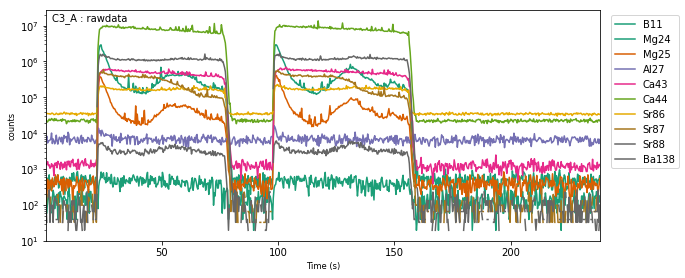

In [4]:
sample = 'C3_A'  # modify to change which is plotted throughout.
_ = dat.data[sample].tplot()

## Data Processing

In [5]:
dat.despike()

Despiking: 100%|██████████| 27/27 [00:00<00:00, 640.15it/s]


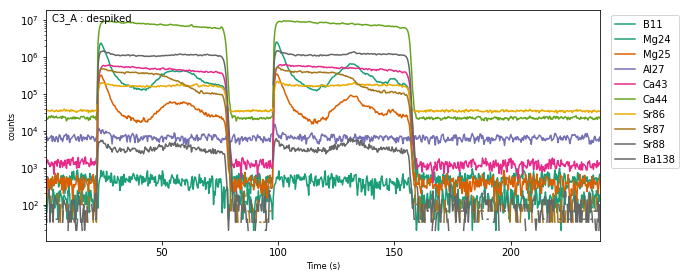

In [6]:
_ = dat.data[sample].tplot()

In [7]:
dat.autorange(on_mult=[2, 1], off_mult=[1, 3])

AutoRange: 100%|██████████| 27/27 [00:01<00:00, 15.32it/s]


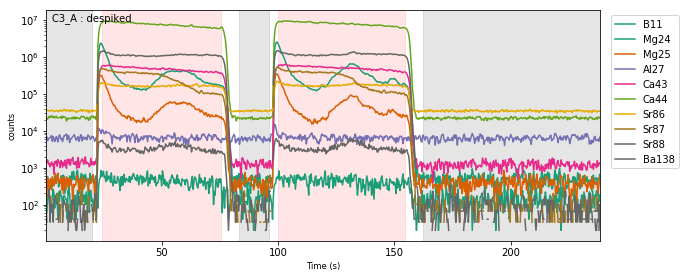

In [8]:
_ = dat.data[sample].tplot(ranges=True)

In [9]:
dat.bkg_calc_weightedmean(weight_fwhm=800, n_min=60, bkg_filter=True)

Plotting backgrounds: 100%|██████████| 10/10 [00:01<00:00,  8.79it/s]


(<Figure size 540x360 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f467a5257b8>)

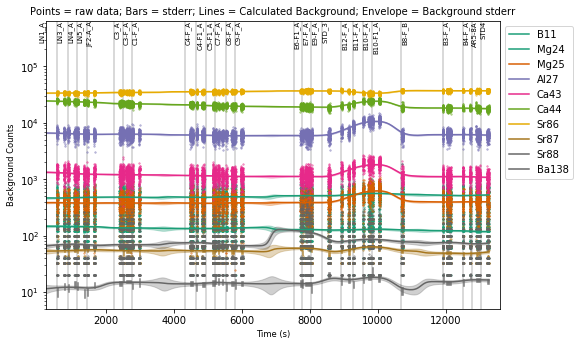

In [10]:
dat.bkg_plot()

Sr backgrounds a little odd - check autorange isn't erroneously including 'signal' in the background regions:

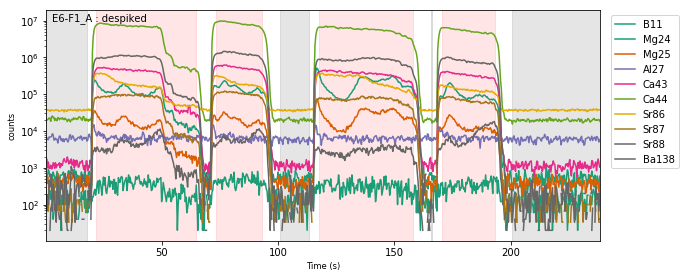

In [11]:
_ = dat.data['E6-F1_A'].tplot(ranges=True)

Looks fine - proceed with background correction

In [12]:
dat.bkg_subtract()

Background Subtraction: 100%|██████████| 27/27 [00:04<00:00,  8.06it/s]


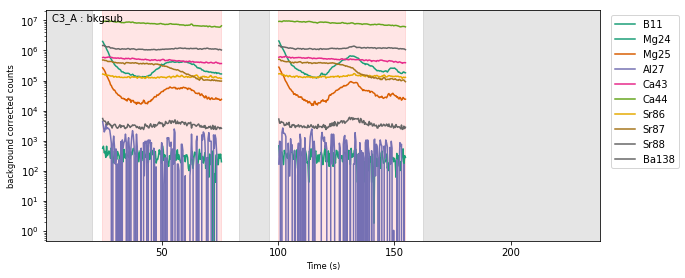

In [13]:
_ = dat.data[sample].tplot(ranges=True)

In [14]:
dat.ratio()

Ratio Calculation: 100%|██████████| 27/27 [00:00<00:00, 25.27it/s]


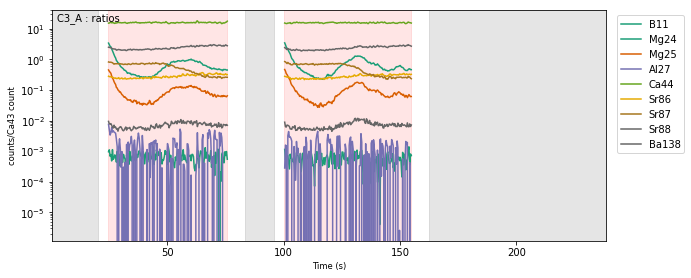

In [15]:
_ = dat.data[sample].tplot(ranges=True)

In [16]:
dat.calibrate(srms_used=['NIST610', 'NIST612', 'NIST614'])

Applying Calibrations: 100%|██████████| 27/27 [00:03<00:00,  7.19it/s]


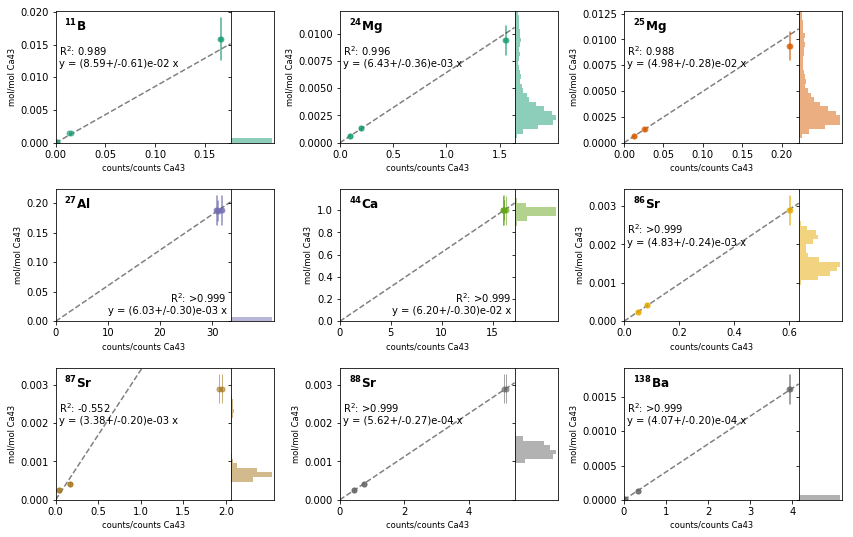

In [17]:
_ = dat.calibration_plot()

The Sr87 calibration has a non-zero intercept, suggesting a possible isobaric interference. As we are not seeking to quantitatively determine Sr87 in these samples (it is used as a marker only), we will continue using a calibration line with a non-zero intercept. 

In [18]:
dat.calibrate('Sr87', srms_used=['NIST610', 'NIST612', 'NIST614'], zero_intercept=False)

Applying Calibrations: 100%|██████████| 27/27 [00:00<00:00, 71.83it/s]


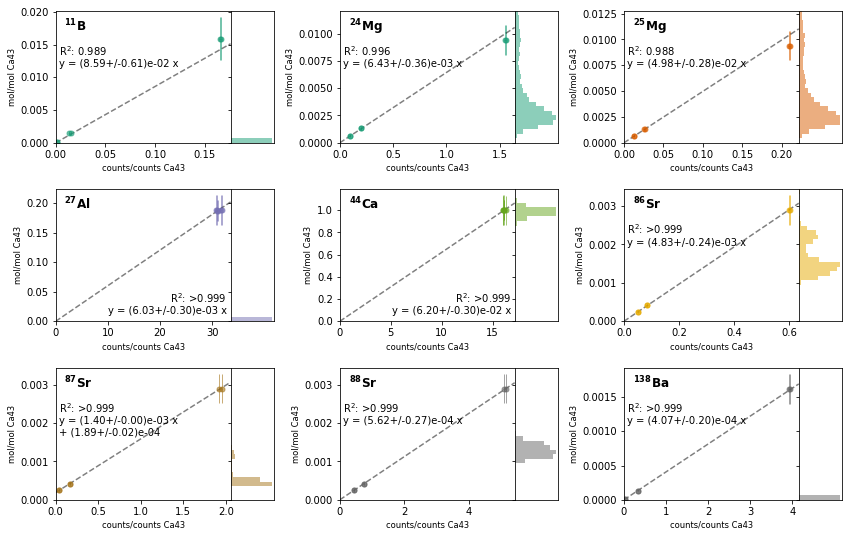

In [19]:
_ = dat.calibration_plot()

## Filtering

In [20]:
dat.filter_clear()

These data contain analyses of *O. universa* and *N. dutertreii*. These need to be treated separately during filtering, so we divide the data into two subsets.

In [21]:
# subsets
dat.make_subset([s for s in dat.samples if (s[0] == 'B') | (s[0] == 'C') | (s[0] == 'E')], 'dut')
dat.make_subset([s for s in dat.samples if (s[0] != 'B') & (s[0] != 'C') & (s[0] != 'E') & (s[0] != 'S')], 'orb')

'orb'

### *O. universa*

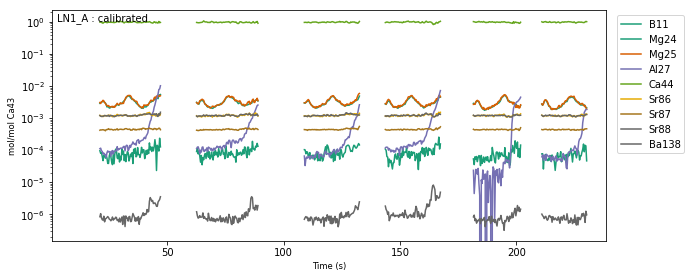

In [22]:
_ = dat.data['LN1_A'].tplot(filt=False)

Drawing Plots: 100%|██████████| 36/36 [00:00<00:00, 283.80it/s]


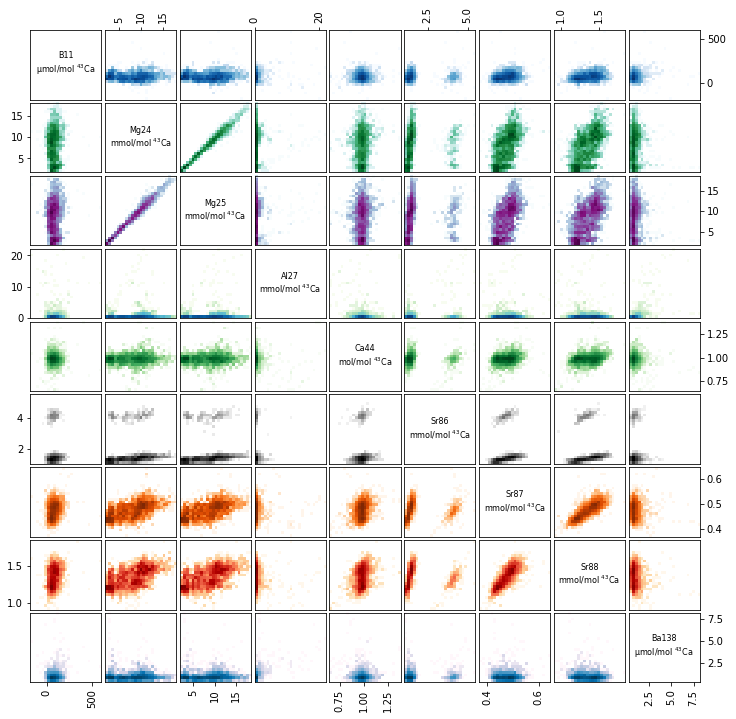

In [23]:
_ = dat.crossplot(subset='orb')

The data look fairly clean. High Al27 values are indicative of the carbon tape used to mount the specimens, and should be removed.

The two  clusters in Sr87/Sr88 indicate material grown in or out of culture conditions, which were elevated in Sr86.

In [24]:
dat.filter_clear(subset='orb')
dat.filter_threshold('Al27', 0.2e-3, subset='orb')
dat.filter_on('below', subset='orb', show_status=True)

Threshold Filter: 100%|██████████| 6/6 [00:00<00:00, 1218.21it/s]

Subset: orb
Samples: LN1_A, LN3_A, LN4_A, LN5_A, JF2-A_A, AR5-8A

n  Filter Name          B11    Mg24   Mg25   Al27   Ca43   Ca44   Sr86   Sr87   Sr88   Ba138  
0  Al27_thresh_below    True   True   True   True   True   True   True   True   True   True   
1  Al27_thresh_above    False  False  False  False  False  False  False  False  False  False  



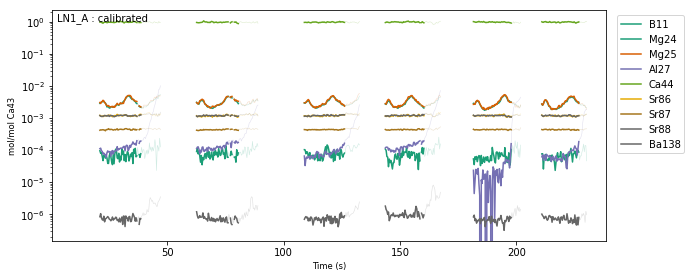

In [25]:
_ = dat.data['LN1_A'].tplot(filt=True)

### *N. dutertrei*

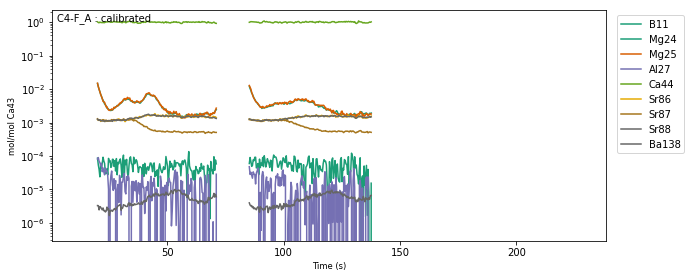

In [26]:
_ = dat.data['C4-F_A'].tplot(filt=False)

Drawing Plots: 100%|██████████| 36/36 [00:00<00:00, 230.73it/s]


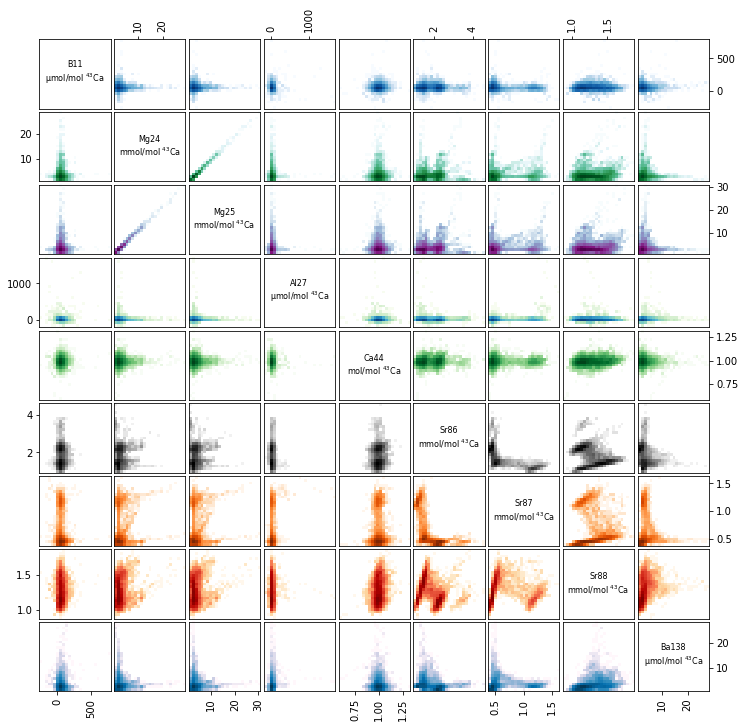

In [27]:
_ = dat.crossplot(subset='dut')

Similarly, the *dutertrei* data look relatively clean, with two distinct data populations representing culture grown and wild-grown calcite.

Apply a few threshold filters to remove some of the high outliers.

In [28]:
dat.filter_clear(subset='dut')
dat.filter_threshold('Al27', 0.1e-3, subset='dut')
dat.filter_threshold('Ba138', 6e-6, subset='dut')
dat.filter_threshold('Mg24', 15e-3, subset='dut')
dat.filter_on('Ba138_thresh_below', subset='dut')
dat.filter_on('below', subset='dut', show_status=True)

Threshold Filter: 100%|██████████| 19/19 [00:00<00:00, 2327.04it/s]

Subset: dut
Samples: C3_A, C3-F_A, C1-F_A, C4-F_A, C4-F1_A, C5-F1_A, C7-F_A, C8-F_A, C9-F_A, E6-F1_A, E7-F_A, E9-F_A, B12-F_A, B11-F_A, B10-F_A, B10-F1_A, B8-F_B, B3-F_A, B4-F_A

n  Filter Name           B11    Mg24   Mg25   Al27   Ca43   Ca44   Sr86   Sr87   Sr88   Ba138  
0  Al27_thresh_below     True   True   True   True   True   True   True   True   True   True   
1  Al27_thresh_above     False  False  False  False  False  False  False  False  False  False  
2  Ba138_thresh_below    True   True   True   True   True   True   True   True   True   True   
3  Ba138_thresh_above    False  False  False  False  False  False  False  False  False  False  
4  Mg24_thresh_below     True   True   True   True   True   True   True   True   True   True   
5  Mg24_thresh_above     False  False  False  False  False  False  False  False  False  False  



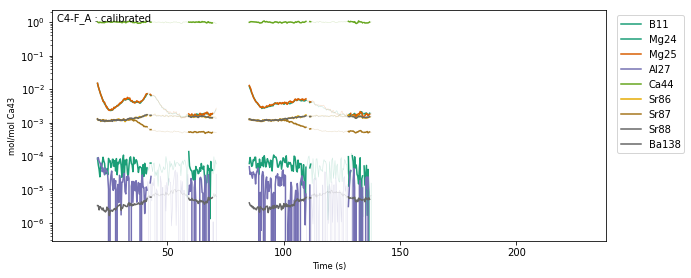

In [29]:
_ = dat.data['C4-F_A'].tplot(filt=True)

In [30]:
dat.filter_exclude_downhole(5, subset='dut')
dat.filter_off(subset='dut')
dat.filter_on('downhole', subset='dut')

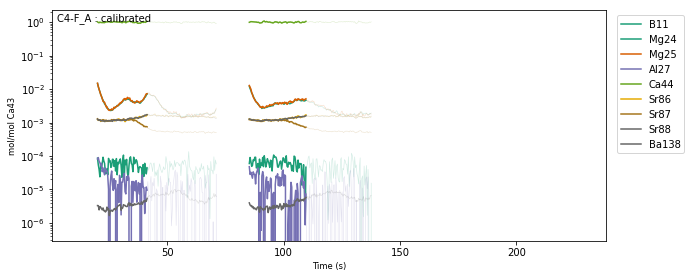

In [31]:
_ = dat.data['C4-F_A'].tplot(filt=True)

In [32]:
dat.sample_stats(stats=['mean', 'std', 'stderr'])

Calculating Stats: 100%|██████████| 27/27 [00:00<00:00, 53.77it/s]


In [33]:
ld = dat.getstats().loc['mean'] * 1e3

## Compare Data

In [34]:
rd = helpers.load_reference_data('culture_reference')
td = helpers.load_reference_data('culture_test')
# ld = helpers.read_latools_data('Jenn_Data_export/clean_Alfilt.csv')

# combine all data
df = rd.join(td, lsuffix='_r', rsuffix='_t')
df = df.join(ld)

In [35]:
# number of unique samples
np.unique(rd.index.levels[0]).size

33

## Characterise Inter-Replicate Reproducibility

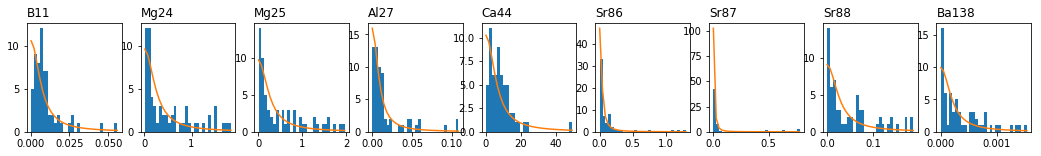

In [36]:
_ = stats.pairwise_reproducibility(ld, plot=True)

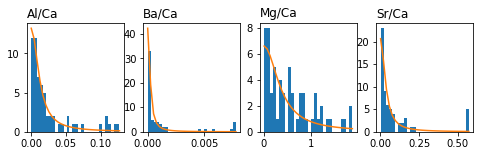

In [37]:
_ = stats.pairwise_reproducibility(td, plot=True)

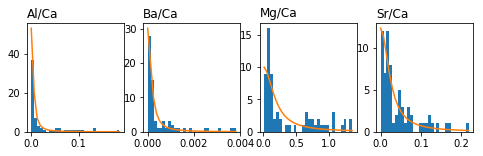

In [38]:
_, rep_dists, rep_stats, _ = stats.pairwise_reproducibility(rd, plot=True)

In [39]:
rep = pd.DataFrame(rep_stats).T
rep.columns = ['50%', '95%']
rep = rep.loc[['Mg/Ca', 'Sr/Ca', 'Ba/Ca', 'Al/Ca'],:]

In [40]:
rep.to_csv('reproducibility_quants.csv')

## Compare Data

In [41]:
# fig, axs = plots.comparison_plots(df, els=['Mg', 'Sr', 'Ba', 'Al'])

In [42]:
# fig, axs = plots.residual_plots(df, rep_stats, els=['Mg', 'Sr', 'Ba', 'Al'])

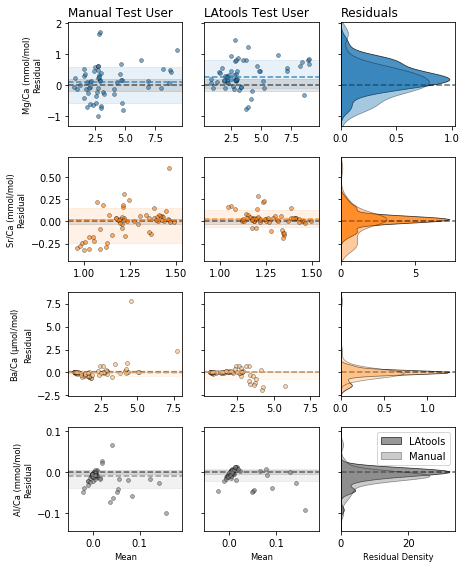

In [43]:
fig, axs = plots.bland_altman_plots(df, rep_stats=rep_stats, els=['Mg', 'Sr', 'Ba', 'Al'])

fig.savefig('Figures/culture_comparison.pdf')
fig.savefig('Figures/culture_comparison.png', dpi=200)

## Comparison Stats

In [44]:
stat = stats.comparison_stats(df, els=['Mg', 'Sr', 'Ba', 'Al'])

In [45]:
stat.to_csv('Stats/culture_stats.csv')

In [46]:
stat['Test User']

Residual Summary                                                \
                     N      Median         LQ        IQR          UQ   
Mg/Ca               58    0.110929  -0.209317   0.589884    0.380567   
Sr/Ca               58   0.0126133  -0.134795    0.19071    0.055915   
Ba/Ca               58 -0.00175805  -0.173678   0.237852    0.064174   
Al/Ca               58 -0.00979209 -0.0191629  0.0137064 -0.00545648   

      Residual Regression                                                  \
                    Slope    Slope t      Slope p   Intercept Intercept t   
Mg/Ca           0.0251354    0.75898     0.451047   0.0071223   0.0524345   
Sr/Ca          -0.0109954 -0.0616828     0.951035 -0.00204797 -0.00913788   
Ba/Ca           0.0401601   0.362272     0.718513   0.0548817     0.19363   
Al/Ca           -0.354314   -6.10224  1.03594e-07  -0.0062644    -2.24782   

                               Kolmogorov-Smirnov               
      Intercept p           R2                 KS            p  
Mg/Ca    0.958369    0.0101819           0.137931     0.606755  
Sr/Ca    0.992742  6.79377e-05           0.189655     0.222094  
Ba/Ca    0.847166    0.0023381           0.137931     0.606755  
Al/Ca   0.0285442     0.399382           0.517241  1.60669e-07

In [47]:
stat['LAtools']

Residual Summary                                                  \
                     N       Median          LQ        IQR          UQ   
Mg/Ca               59     0.282552   0.0903516   0.504096    0.594447   
Sr/Ca               59    0.0225862  0.00359267  0.0379265   0.0415191   
Ba/Ca               59    0.0301793  -0.0650995   0.146865   0.0817658   
Al/Ca               59 -0.000224888 -0.00998352  0.0147826  0.00479908   

      Residual Regression                                                 \
                    Slope  Slope t      Slope p    Intercept Intercept t   
Mg/Ca           0.0273888  1.03187      0.30649     0.220157      2.0297   
Sr/Ca           -0.380113 -5.46408  1.06537e-06     0.500033     5.73641   
Ba/Ca           -0.262719 -6.40346  3.11563e-08     0.470945     4.48169   
Al/Ca           -0.282028 -6.22127  6.22776e-08 -5.30286e-05  -0.0245569   

                              Kolmogorov-Smirnov             
       Intercept p         R2                 KS          p  
Mg/Ca    0.0470648  0.0183375           0.220339  0.0981537  
Sr/Ca  3.87084e-07   0.343743            0.20339   0.153254  
Ba/Ca  3.62211e-05   0.418393           0.135593   0.617954  
Al/Ca     0.980494   0.404415           0.237288  0.0606463